In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Load and split data

In [20]:
df = pd.read_csv(r"C:\Users\grego\Documents\GitHub\DataVizCaptionGeneration\volume\processed\features.csv")

df.drop("Unnamed: 0", axis=1, inplace=True)

df.head()

,chart_type,has_num_labels,num_labels_x_mean,num_labels_y_mean,num_labels_x_std,num_labels_y_std,sizes_mean,sizes_std,std_center_x,std_centers_y,num_sides_mean,num_sides_std,aspect_ratios_mean,aspect_ratios_std,num_glyphs,chart_fp
0,fit-regression-plot,True,653.0,990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
1,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
2,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
3,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...
4,fit-regression-plot,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,C:\Users\grego\Documents\GitHub\DataVizCaption...


In [21]:
# we don't need this column for the analysis
df.drop("chart_fp", axis=1, inplace=True)

# remove nulls
df.dropna(inplace=True)

X = df.drop("chart_type", axis=1)
y = df.chart_type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model (Random Forest Classifier)

In [34]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Training accuracy:", accuracy_score(y_train, clf.predict(X_train)))
print("Testing accuracy:", accuracy_score(y_test, clf.predict(X_test)))


Training accuracy: 0.8828190158465388
Testing accuracy: 0.7981651376146789


Let's look at overall feature importances

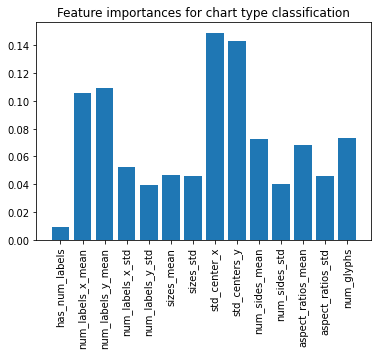

In [32]:
import matplotlib.pyplot as plt

plt.bar(X.columns, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.title("Feature importances for chart type classification")
plt.show()

Now let's look at feature importances for each class.

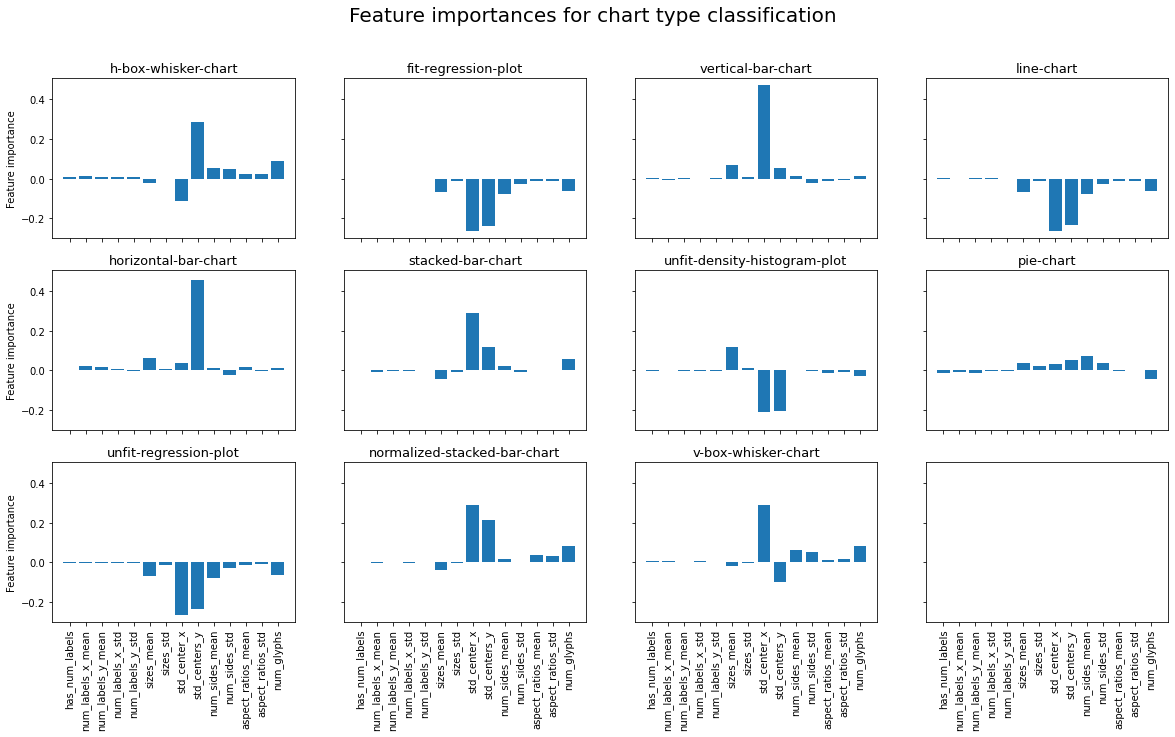

In [88]:
from sklearn.preprocessing import scale
import numpy as np

def class_feature_importance(X, Y, feature_importances):
    # https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharey=True, sharex=True)

for (chart_type, feature_importances), ax in zip(
                class_feature_importance(X, y, clf.feature_importances_).items(),
                axs.flatten()):
    ax.bar(X.columns, feature_importances.values())
    ax.set_title(chart_type, fontsize=13)
    ax.tick_params(axis='x', rotation=90)
    

fig.suptitle("Feature importances for chart type classification", fontsize=20)

axs.flatten()[0].set_ylabel("Feature importance")
axs.flatten()[4].set_ylabel("Feature importance")
axs.flatten()[8].set_ylabel("Feature importance")

plt.xticks(rotation = 90)
plt.show()